In [259]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### This notebook referenced the following resources:
https://see.stanford.edu/course/cs229

https://github.com/stuartzong/stanford-cs229

https://github.com/Sierkinhane/CS229-ML-Implements

https://github.com/benWindsorCode/stanfordMachineLearning
        

#### problem-set1 question 2
The task is to implement locally weighted logisitic regression algorithm (lwlr). lwlr is a modified version of logistic regression. It gives more weights to the training samples, which are close (similar) to the query sample, when predicting the class of a query point. Bandwidth parameter τ plays an important role in terms of assigning weights to training examples. When τ → ∞, lwlr is regular logistic gression. When τ is very small, lwlr may tend to overfit the training data. 

lwlr is to maximize the likelihood of θ:

$$ℓ(θ) = −\frac{λ}{2}θ^Tθ +\sum_{i=1}^{m} (w_{(i)}[y^{(i)}log\ h_θ(x^{(i)}) + (1 − y^{(i)})log(1 − h_θ(x^{(i)})])$$

###### (a) Implement the Newton-Raphson algorithm for optimizing ℓ(θ) for a new query point x, and use this to predict the class of x.

##### Intuition of Newton's method: 
finding f(θ)=0, updating rules: θ = θ - $\frac {f(θ)}{f{'}(θ)}$

i.e. $f(θ) = θ^2, f^{'}(θ)=2θ$

Suppose initial θ=2, $ f(θ)=2^2=4, f^{'}(2)=2*2=4$, $\frac{f(2)}{f^{'}(2)}=1$, after first update,  θ=2-1=1. This is indeed very effective. One single step update moved θ half way closer toward the minimum (θ=0).

The q2/ directory contains data and code for this problem. You should implement
the y = lwlr(X train, y train, x, tau) function in the lwlr.m file. This function takes as input the training set (the X train and y train matrices, in the form
described in the class notes), a new query point x and the weight bandwitdh tau.
Given this input the function should 1) compute weights w
(i)
for each training example, using the formula above, 2) maximize ℓ(θ) using Newton’s method, and finally 3)
output y = 1{hθ(x) > 0.5} as the prediction.

### 1) compute the weight for each training sample given a query $w^{(i)} = e^{-\frac{||x − x^{(i)}||^2}{2τ^2}}$

We can think of the norm of a vector as the distance between origin and the vector. Numpy default norm is Frobenius norm, which is the sum of all squared elements. $np.linalg.norm(A)=\sqrt{\sum_{i,j=1}^{m,n}(A_{ij}^2)}$
.

In [260]:
# arbitrary parameters
lb = 0.0001
tau = 0.01
thetas = np.zeros(3) 


In [261]:
# look at the data first
X_train = np.loadtxt("data/x.dat")
Y_train = np.loadtxt("data/y.dat")
# add ones to the first column 
X_train = np.append(np.ones((m,1)), X_train, axis=1)
X_train[:2,:]
Y_train[:2]
m, n = X_train.shape
m, n

array([[ 1.        , -0.34792627,  0.8625731 ],
       [ 1.        , -0.14516129,  0.62865497]])

array([0., 0.])

(69, 3)

,0,1,2,3
0,1.0,-0.347926,0.862573,0.0
1,1.0,-0.145161,0.628655,0.0


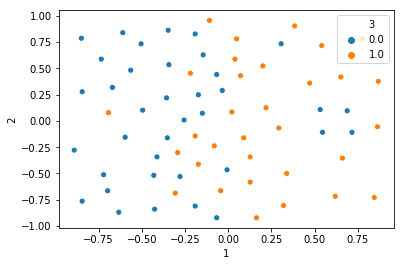

In [262]:
data = np.concatenate((X_train, Y_train[:,None]), axis=1)
df = pd.DataFrame(data)
df.head(2)
# look at the data first
sns.scatterplot(1,2, data=df, hue=3)

In [263]:
def compute_weight_single(x_train, x_query,tau):
    w = np.exp(-np.linalg.norm(x_query - x_train)**2/2/tau**2)
    return w
    
def compute_weight_vector(X_train, x_query, tau):
    return np.array([compute_weight_single(x_train, x_query, tau) for x_train in X_train])

In [264]:
# given a query point to see how the weights are assigned
x_query = np.array([1, 0.3, 0.5])
W = compute_weight_vector(X_train, x_query, tau)
W[50:]
# should the sum of weigths for all training examples is 1?
W.sum()

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 2.43677716e-300,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 7.21155033e-125, 3.64384808e-165, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

1.9804843619510394e-23

### Logistic function and logistic regression hypothesis

This is logistic function(sigmoid function) g: $g(z) = \frac{1}{1+e^{-z}}$. 

This is logistic regression hypothesis: $h_θ(x) = g(θ^Tx)=\frac{1}{1+e^{-θ^Tx}}$

In [265]:
def g(z):
    return 1/(1+np.exp(-z))

In [266]:
def h(x, theta):
    z = x @ theta #theta = theta.T, np automatically change column vector to row
    return g(z)

In [267]:
# before training the hypothesis has no idea what to predict
preds = h(X_train, thetas)
preds.shape
preds

(69,)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5])

### now i need to maximize ℓ(θ) using Newton method

locally weighted logistic regression is to maximize the likelihood of θ:

$$ℓ(θ) = −\frac{λ}{2}θ^Tθ +\sum_{i=1}^{m} (w_{(i)}[y^{(i)}log\ h_θ(x^{(i)}) + (1 − y^{(i)})log(1 − h_θ(x^{(i)})])$$

Using this definition, the gradient of ℓ(θ) is given by
$∇_θℓ(θ) = X^Tz − λθ$

where $z ∈ R^m$ is defined by
$z_i = w^{(i)}(y^{(i)} − h_θ(x^{(i)}))$

Hessian matrix is the second partial derivatives, f(x1, x2, ... xn), H is a nxn matrix.
$H_{ij}= \frac{\partial ^2f}{\partial x_i\partial x_j}$ 

and the Hessian is given by
$H = X^TDX − λI$

where D ∈ R
m×m is a diagonal matrix with
$D_{ii} = −w^{(i)}h_θ(x^{(i)})(1 − h_θ(x^{(i)}))$

### Generalization of newton's method, Newton Raphson method;
θ updating rules: $ θ = θ - H^{-1}\nabla_θℓ(θ)$

In [268]:
def diagonal_matrix(W, X, thetas):
    m = X.shape[0]
    D = np.zeros((m, m))
    preds = h(X, thetas)
    for i, (w, x, p) in enumerate(zip(W, X, preds)):       
        d = -w * p * (1 - p)
        D[i,i] = d
    return D


In [269]:
def hessian(X, D, lb): #lb=lambda
    m =  X.shape[1]
    return X.T @ D @ X - lb * np.eye(n)
    

In [270]:
X_train.shape
D.shape
lb

(69, 3)

(69, 69)

0.0001

In [271]:
hessian(X_train, D, lb)

array([[-1.00000000e-04, -9.70938559e-25, -2.53506528e-24],
       [-9.70938559e-25, -1.00000000e-04, -5.08181290e-25],
       [-2.53506528e-24, -5.08181290e-25, -1.00000000e-04]])

In [272]:
def z(w, y, y_hat): # single training sample
    return w * (y - y_hat)
    

In [273]:
def z_vector(W, Y, Y_hat):
    return [z(w, y, y_hat) for w, y, y_hat in zip(W, Y, Y_hat)]

In [274]:
Y_hat = h(X_train, thetas)


In [275]:
def gradient_theta(X, Z, lb, thetas):
    return X.T @ Z - lb * thetas
    

In [276]:
def update_theta(X_train, x_query, Y_train, thetas, lb, tau):
    W = compute_weight_vector(X_train, x_query, tau)
    Y_hat = h(X_train, thetas)
    D = diagonal_matrix(W, X_train, thetas)
    Z = z_vector(W, Y_train, Y_hat)
    grad_thetas = gradient_theta(X_train, Z, lb, thetas)
    H = hessian(X_train, D, lb)
    thetas_up = thetas - np.linalg.inv(H) @ grad_thetas 
#     print(f'upding theta from {thetas} to {thetas_up}')
    return (thetas_up, grad_thetas)

In [277]:
def predict(X_train, Y_train, x_query, tau):
    '''lwlr need to keep all the training samples in the memory, and assign weights to
       different samples based on the distance between the query and the training samples
    '''
    grad_thetas = np.ones(X_train.shape[1])
    thetas = np.zeros(X_train.shape[1])
    while np.linalg.norm(grad_thetas > 1e-6):
        thetas, grad_thetas = update_theta(X_train, x_query, Y_train, thetas, lb, tau)
    Y_hat = h(x_query, thetas)
    pred = np.where(Y_hat>0.5, 1, 0)
#     print(f'predicted class is {pred}')
    return pred

In [278]:
update_theta(X_train, x_query, Y_train, thetas, lb, tau)

(array([9.90242181e-20, 1.98504769e-20, 5.18284647e-20]),
 array([9.90242181e-24, 1.98504769e-24, 5.18284647e-24]))

### training algorithm

In [279]:
x_query = np.array([1,-0.1, 0.5])
thetas = np.zeros((X_train.shape[1],1))
taus = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 1e12]
tau=.1
lb = 0.0001
grad_thetas = np.ones(X_train.shape[1])

In [280]:
# while np.linalg.norm(grad_thetas > 1e-6):
#     thetas, grad_thetas = update_theta(X_train, x_query, Y_train, thetas, lb, tau)
#     print(thetas)
# trainedTheta = lwlr(xData, yData, xTrain, tau)
# predict(x_query, thetas)

In [281]:
thetas
grad_thetas

array([[0.],
       [0.],
       [0.]])

array([1., 1., 1.])

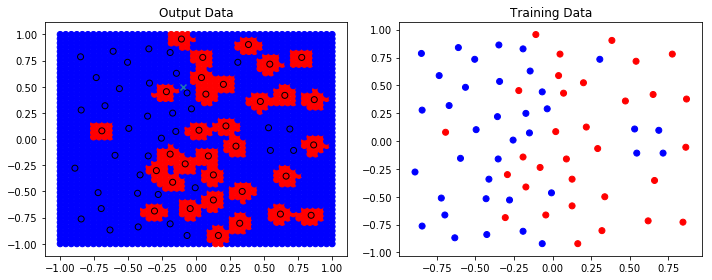

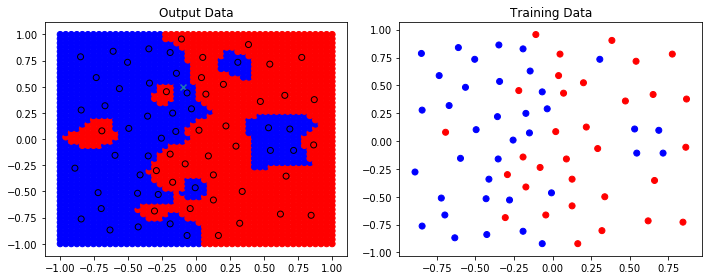

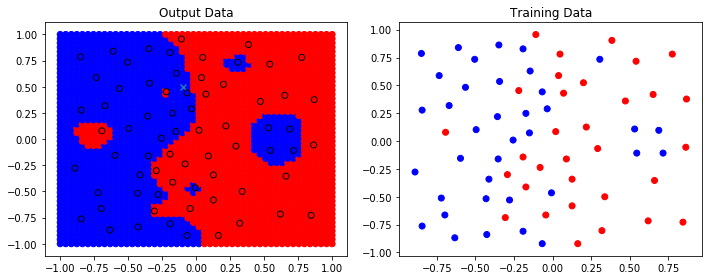

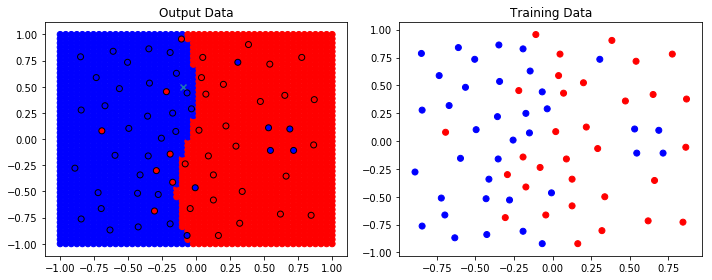

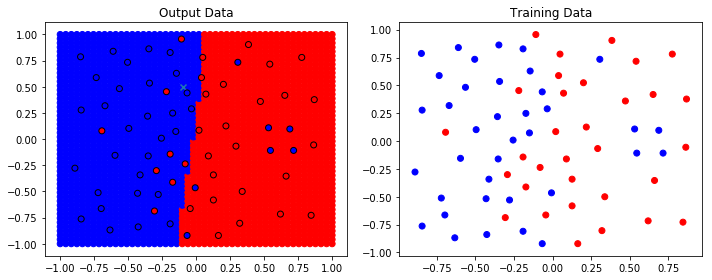

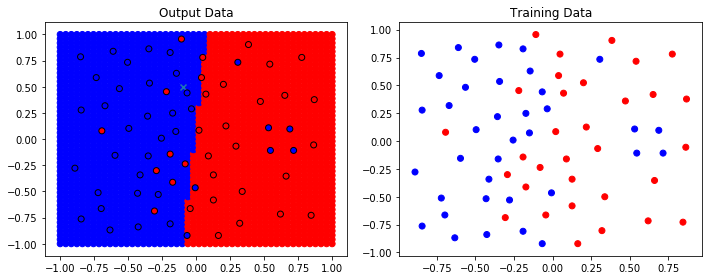

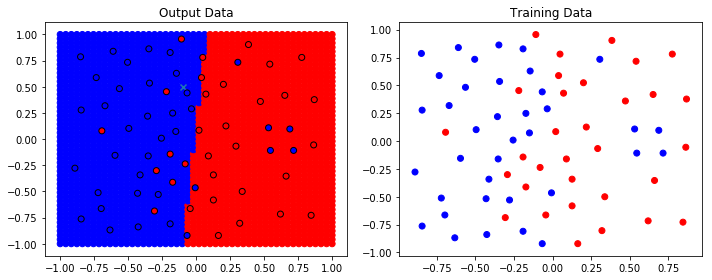

In [283]:
for tau in taus:
    res=50
    baseGridSpacing = np.linspace(-1,1,res)
    xSpace = np.asarray([])
    ySpace = np.asarray([])
    for i in baseGridSpacing:
        xSpace=np.append(xSpace,(np.linspace(-1,1,res)))
    for i in baseGridSpacing:
        ySpace=np.append(ySpace, np.full((res,1),i))

    labels = [predict(X_train, Y_train, np.array([1, j, i]), tau) for i in baseGridSpacing for j in baseGridSpacing] 
    colour= ['red' if l == 1 else 'blue' for l in labels]

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
    _ = ax1.scatter(xSpace, ySpace, c=colour)
    _ = ax1.scatter(x_query[1], x_query[2], marker='x')
    
    _ = ax1.set_title("Output Data")

    labels = np.array(Y_train.astype(int))
    colour= ['red' if l == 1 else 'blue' for l in labels]
    _ = ax2.scatter(X_train[:,1], X_train[:,2],c=colour)
    _ = ax2.set_title("Training Data")
    # add in training point on top of decision boundary, color points based on the real labels
    _ = ax1.scatter(X_train[:,1], X_train[:,2],c=colour, edgecolors='black')

    _ = plt.tight_layout()

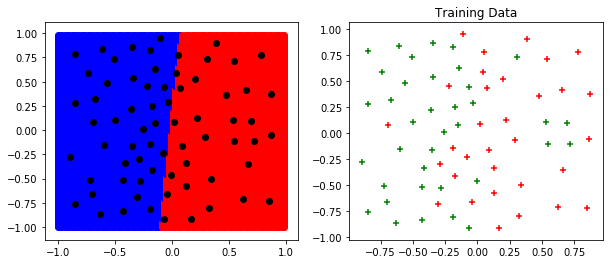

In [284]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
res = 100
x = np.zeros([2, 1])

# plot training set
labels = np.array(Y_train.astype(int))
colour= ['red' if l == 1 else 'green' for l in labels]
_ = ax2.scatter(X_train[:,1], X_train[:,2],c=colour,marker='+')
_ = ax2.set_title("Training Data")

for i in range(1, res):
    for j in range(1, res):
        xi = 2*(i-1)/(res-1) - 1
        xj = 2*(j-1)/(res-1) - 1
        x_query = np.array([1, xi, xj])
        pred =  predict(X_train, Y_train, x_query, tau)
        c = 'red' if pred==1 else 'blue'
        _ = ax1.scatter(xi, xj, c=c, marker='o')
_ = ax1.scatter(X_train[:,1], X_train[:,2],c='black',marker='o')